# desc-wfmon/montab.ipynb: Monitor table viewing example

We use the classes in desc-wfmon to examine one of the monitoring tables from DESC gen3 parsl jobs.

Copy this file to the run directory or modiufy variable *dir* below.

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
!pwd
%run install/setup.py
import sys
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")

/global/u2/d/dladams/desc/rundirs/ptest05
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda:/global/u2/d/dladams/desc/rundirs/ptest05:
TestMonDbReader:ctor: Done.
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/wfmon/__init__.py'> version is 0.0.16.dev2
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/sysmon/__init__.py'> version is 0.0.16.dev2


## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [2]:
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

mb = 2**20
gb = 2**30
bunit = gb
bunit_sys = bunit/gb
sbunit = 'GB'

dir = f"./"
dirProc = dir + 'runinfo/'
line = '-----------------------------------------------------------'

## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
sym = pandas.read_csv(dir + 'sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 716
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 128
Total memory is 251.3 GB


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
dbr = desc.wfmon.MonDbReader(dirProc + 'monitoring.db', dodelta=True)
print(line)
dbr.tables(2)

-----------------------------------------------------------
DB ./runinfo/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
    object   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 2159 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_returned
     int64   task_fail_count
   float64   task_fail_cost
*******************************************************
Table try has 2160 ro

## procsum
Look at the procsum table

In [5]:
psm = dbr.table("procsumDelta")
print(pandas.get_option('display.width'))
pandas.set_option('display.width', 160)
pandas.set_option('display.max_columns', 20)
#print(psm)

80


In [6]:
taskid=255
olddf = dbr.table('resource').query(f"task_id=={taskid}")[['timestamp', 'psutil_process_time_user']].sort_values(by=['timestamp'])
print(olddf.diff())
#print(dbr.table('resource').query('task_id==255')['timestamp'].sort_values())

Empty DataFrame
Columns: [timestamp, psutil_process_time_user]
Index: []


In [7]:
taskid = 255
dt = 1
toff = 0
dtoff = 0.1
maxdif = 0
while len(olddf) > 2:
        maxdif = max(olddf.timestamp.add(toff).mod(dt).diff()[2:].abs())
        print(toff, maxdif)
        if maxdif < dt/2.: break
        if toff > dt/2 + 1:
            print(f"""WARNING: Unable to find offset for run task {taskid}. Using 0.0.""")
            toff = 0.0
            break
        toff = toff + dtoff
print(f"toff = {toff}, maxdif = {maxdif}")

toff = 0, maxdif = 0


In [8]:
print(dbr.taskproc(0, 255, False))

None


In [11]:
if dbr.taskproc(0,255) is not None: print(dbr.taskproc(0,255)['timestamp'])

In [12]:
print(dbr.taskproc(0,33))

     timestamp  run_idx  task_idx  task_id  try_id  toff  procdel_time_clock  nsam  isam  proc_pid proc_status  proc_memory_percent  proc_memory_resident  \
0   907.477025        0         1       33       0   0.0            1.006430    19     0    107582     running             0.172406          4.651622e+08   
1   909.560004        0         1       33       0   0.0            2.082979    19     1    107582    sleeping             0.172660          4.658463e+08   
2   912.559855        0         1       33       0   0.0            2.999851    19     2    107582    sleeping             0.174131          4.698153e+08   
3   915.559811        0         1       33       0   0.0            2.999956    19     3    107582    sleeping             0.174324          4.703355e+08   
4   918.558702        0         1       33       0   0.0            2.998891    19     4    107582    sleeping             0.181592          4.899471e+08   
5   921.575855        0         1       33       0   0.0  

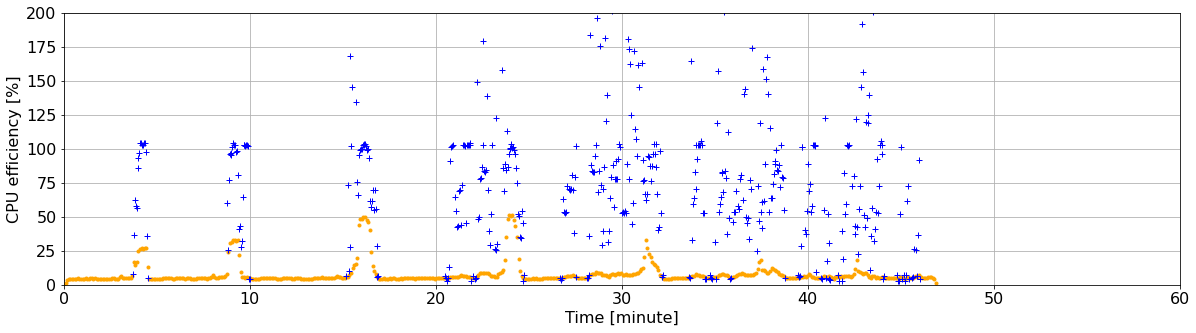

In [13]:
pdx = 20
pdy = 5
minute = 60
hour = 3600
day = 24*hour
tunit = minute
stunit = 'minute'
t0sec = dbr.t0
delt = dbr.monitoring_interval
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)
tmin = 0
tmax = 60

psm = dbr.table('procsum')
psm['tfix'] = psm.timestamp/tunit
sym['tfix'] = (sym.time - t0sec)/tunit
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, sym.cpu_percent, '.', color='orange')
plt.plot(psm.tfix, 100*(psm.procsum_time_user+psm.procsum_time_system)/psm.procsum_time_clock, 'b+')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU efficiency [%]')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 200])

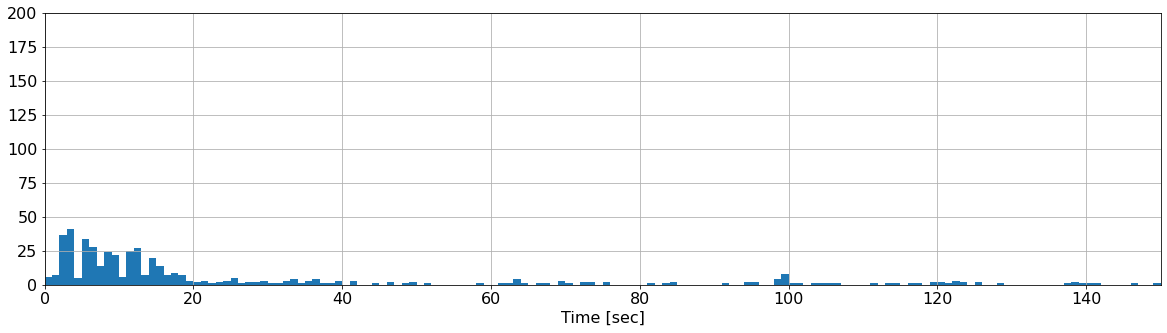

In [14]:
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=150, range=(0,150), x=psm.procsum_time_clock)
plt.xlabel(f"Time [sec]")
plt.grid(True)
junk = plt.axis([tmin, 150, 0, 200])

In [15]:
print(f"Maximum number of tries is {dbr.table('try')['try_id'].max()}")

Maximum number of tries is 1


In [16]:
fda = desc.wfmon.FunctionData()
print(fda.data)

    taskid              start         postimport          mainstart       loadfunction    executefunction               dump               done
0      2.0  1647371405.410544  1647371488.956162  1647371488.956167  1647371488.956213  1647371600.627458  1647371657.927797  1647371657.927836
1      3.0  1647371406.113718  1647371493.531129  1647371493.531134  1647371493.531176  1647371607.463045  1647371655.676391  1647371655.676436
2      4.0  1647371406.116491  1647371493.477909  1647371493.477913  1647371493.477956  1647371607.474658  1647371653.061144  1647371653.061199
3      5.0  1647371405.395503  1647371490.547034  1647371490.547039  1647371490.547088  1647371605.419481  1647371653.917102  1647371653.917147
4      6.0   1647371405.43444  1647371488.735765   1647371488.73577  1647371488.735817  1647371599.262793  1647371654.166623  1647371654.166671
..     ...                ...                ...                ...                ...                ...                ...            

ptest05
['start', 'postimport', 'mainstart', 'loadfunction', 'executefunction', 'dump', 'done']


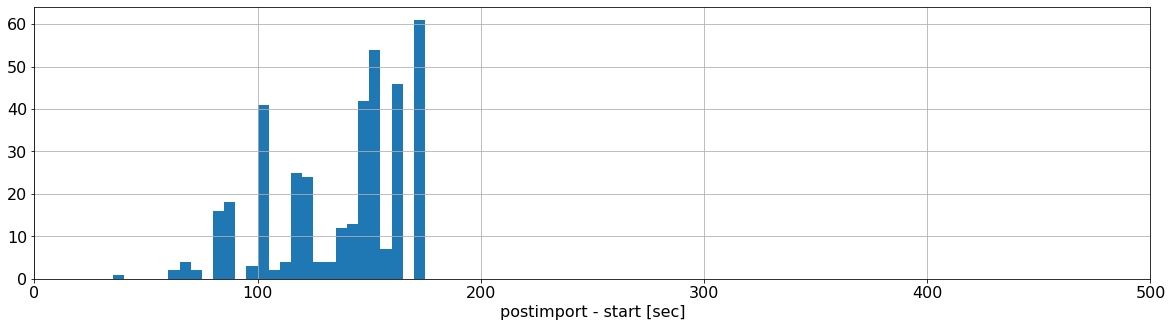

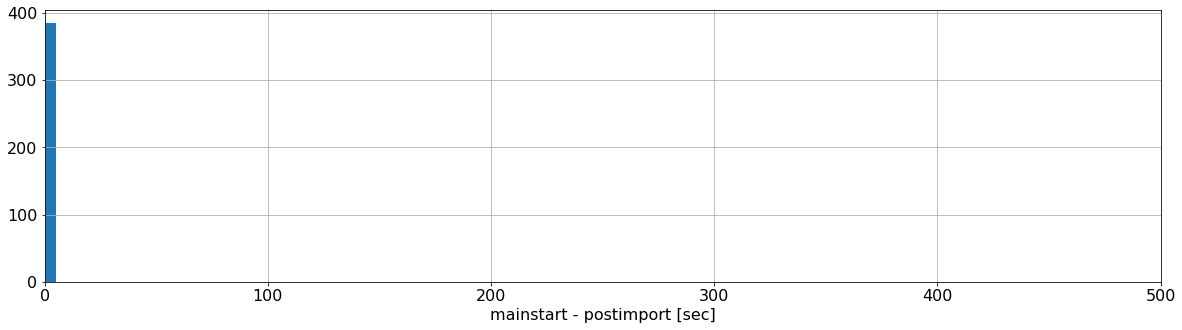

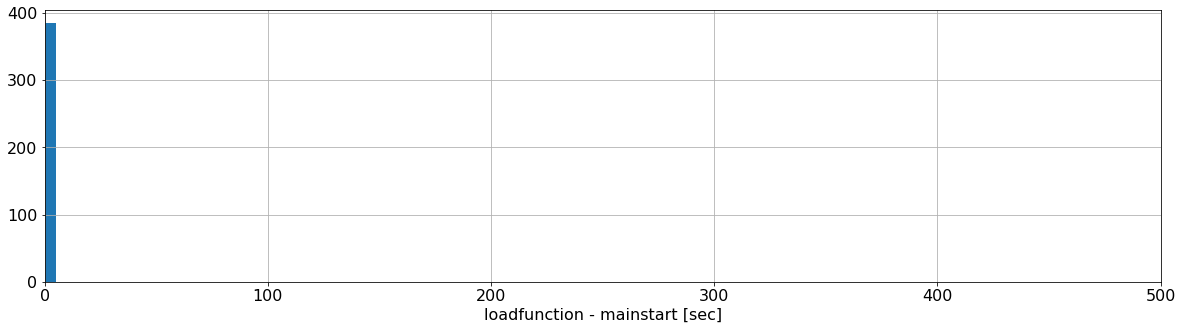

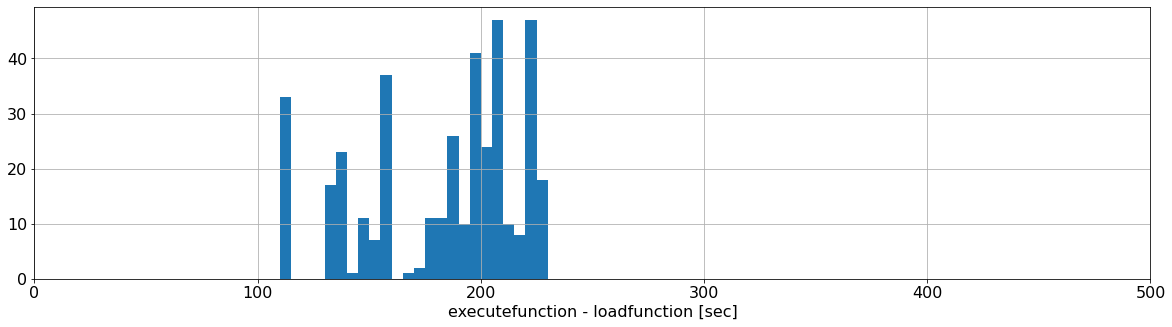

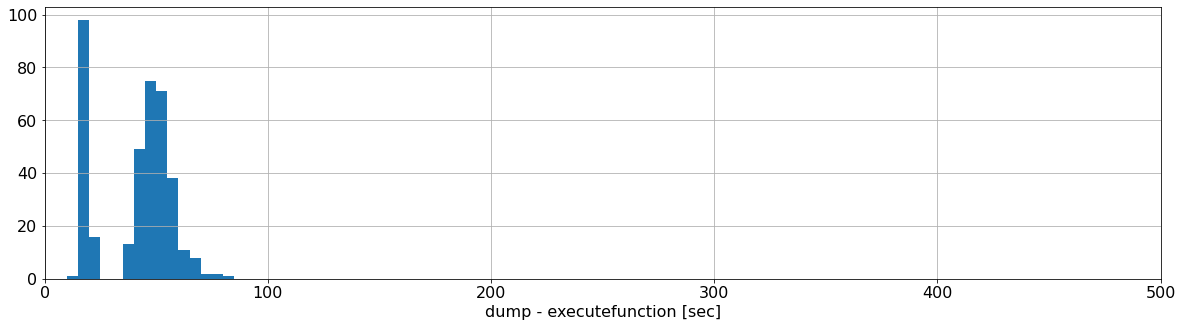

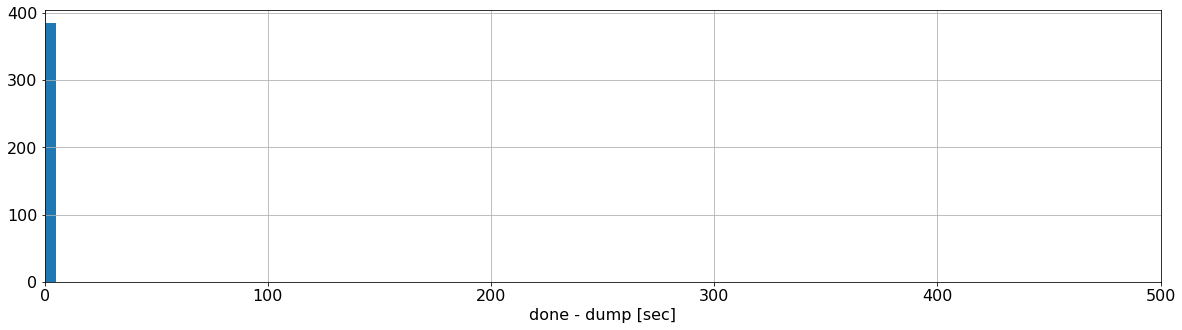

In [17]:
sdir = os.path.basename(os.getcwd())
print(sdir)
nbin = 100
t1 = 0.0
t2 = 500.0
delt = 1.e-5*(t2-t1)
cols = list(fda.data.columns)[1:]
print(cols)
c12s = []
for icol in range(len(cols)-1):
    c12s.append([cols[icol], cols[icol+1]])

#c12s = [['start', 'done'], ['loadfunction', 'executefunction'], ['start', 'loadfunction']]
for [c1, c2] in c12s:
    plt.figure(figsize=(pdx, pdy))
    dif = (fda.data[c2] - fda.data[c1]).clip(lower=t1+delt, upper=t2-delt)
    plt.hist(bins=nbin, range=[t1,t2], x=dif)
    plt.xlabel(f"{c2} - {c1} [sec]")
    plt.grid(True)
    plt.xlim(t1, t2)
    plt.savefig(f"{sdir}-{c1}-{c2}.png")
    plt.show()
#junk = plt.axis([tmin, tmax, 0, 200])